In [1]:
import torch
from torch import nn
from py09_FashionMNIST_Dataset import load_data_fashion_mnist,get_fashion_mnist_labels
from deeplearn_tools import *

In [2]:
def dropout_layer(X,P_dropout):
    assert 0 <= P_dropout <=1
    if P_dropout ==1:
        return torch.zeros_like(X)
    if P_dropout == 0:
        return X
    mask = (torch.randn(X.shape)>P_dropout).float()
    # 做乘法比索引X[mask]计算复杂度低
    return mask * X / (1.0 - P_dropout)

In [3]:
a = torch.arange(20)
print(dropout_layer(a,0))
print(dropout_layer(a,1))
print(dropout_layer(a,0.5))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.])


In [4]:
num_inputs,num_hiddens1,num_hiddens2,num_outputs = 784,256,256,10
dropout1,dropout2 = 0.2,0.5

In [5]:
class Net(nn.Module):
    def __init__(self,num_inputs,num_hiddens1,num_hiddens2,num_outputs,is_Training=True):
            super(Net,self).__init__()
            self.num_inputs = num_inputs
            self.num_hiddens1 = num_hiddens1
            self.num_hiddens2 = num_hiddens2
            self.num_outputs = num_outputs
            self.is_Training = is_Training
            self.flatten = nn.Flatten()
            self.line1_layer = nn.Linear(num_inputs,num_hiddens1)
            self.line2_layer = nn.Linear(num_hiddens1,num_hiddens2)
            self.line3_layer = nn.Linear(num_hiddens2,num_outputs)
            self.relu = nn.ReLU()
    def forward(self,X):
        X = self.flatten(X)
        H1 = self.relu(self.line1_layer(X))
        if self.is_Training is True:
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.line2_layer(H1))
        if self.is_Training is True:
            H2 = dropout_layer(H2,dropout2)
        result = self.line3_layer(H2)
        return result

In [6]:
def evaluate_accuracy(net,data_iter):
    net.is_Training = False
    metric = Accumulator(2)
    for x,y in data_iter:
        y_hat = net(x)
        predic_ls = y_hat.argmax(dim=-1)
        cmp = predic_ls.reshape(y.shape).type(y.dtype) == y
        metric.add(cmp.sum(),y.numel())
    net.is_Training = True
    return metric[0]/metric[1]

In [7]:
net = Net(num_inputs,num_hiddens1,num_hiddens2,num_outputs,is_Training=True)
loss = nn.CrossEntropyLoss()
Optimizer = torch.optim.SGD(net.parameters(),lr = 0.1)

In [8]:
num_epochs,batch_size = 10,256
train_iter,test_iter = load_data_fashion_mnist(batch_size)

In [9]:
def train(num_epochs,train_iter,test_iter,net,loss,Optimizer):
    anim = Animator(xlabel="epoch",xlim=[1,num_epochs],legend=['train_loss','train_acc','test_acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        for x,y in train_iter:
            y_hat = net(x)
            l = loss(y_hat,y)
            Optimizer.zero_grad()
            l.backward()
            Optimizer.step()
            metric.add(l*y.numel(),y.numel())
        train_loss = metric[0]/metric[1]
        train_acc = evaluate_accuracy(net,train_iter)
        test_acc = evaluate_accuracy(net,test_iter)
        anim.add(epoch+1,[train_loss,train_acc,test_acc])

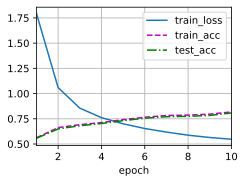

In [10]:
train(num_epochs,train_iter,test_iter,net,loss,Optimizer)

In [11]:
for x,y in train_iter:
    y_hat = net(x)
    break
print(y_hat.shape,y.shape)

torch.Size([256, 10]) torch.Size([256])
